Problem Set #5 - LIGO Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
plt.ion()

dir_data="C:\\Users\\Owner\\Documents\\Fall2020\\Computational\\LOSC_Event_tutorial\\LOSC_Event_tutorial\\"

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

#Read files
fname_h=['H-H1_LOSC_4_V2-1126259446-32.hdf5','H-H1_LOSC_4_V1-1167559920-32.hdf5','H-H1_LOSC_4_V2-1128678884-32.hdf5','H-H1_LOSC_4_V2-1135136334-32.hdf5']
fname_l=['L-L1_LOSC_4_V2-1126259446-32.hdf5','L-L1_LOSC_4_V1-1167559920-32.hdf5','L-L1_LOSC_4_V2-1128678884-32.hdf5','L-L1_LOSC_4_V2-1135136334-32.hdf5']

#Read strains
strain_h=np.zeros((4,131072))
strain_l=np.zeros((4,131072))
dt_h=np.zeros(4) #h and l have should same dt
dt_l=np.zeros(4)
utc_h=['']*4
utc_l=['']*4
for i in range(len(fname_h)):
    print('reading file',fname_h[i])
    strain_h[i,:],dt_h[i],utc_h[i]=read_file(dir_data+fname_h[i])
    print('reading file',fname_l[i])
    strain_l[i,:],dt_l[i],utc_l[i]=read_file(dir_data+fname_l[i])

#Read templates
template_name=['GW150914_4_template.hdf5','GW170104_4_template.hdf5','LVT151012_4_template.hdf5','GW151226_4_template.hdf5']
th=np.zeros((4,131072))
tl=np.zeros((4,131072))
for i in range(len(template_name)):
    th[i,:],tl[i,:]=read_template(dir_data+template_name[i])

reading file H-H1_LOSC_4_V2-1126259446-32.hdf5
reading file L-L1_LOSC_4_V2-1126259446-32.hdf5
reading file H-H1_LOSC_4_V1-1167559920-32.hdf5
reading file L-L1_LOSC_4_V1-1167559920-32.hdf5
reading file H-H1_LOSC_4_V2-1128678884-32.hdf5
reading file L-L1_LOSC_4_V2-1128678884-32.hdf5
reading file H-H1_LOSC_4_V2-1135136334-32.hdf5
reading file L-L1_LOSC_4_V2-1135136334-32.hdf5



Matched Filter Peak Locations:
Hanford [129268. 128582. 129264. 128419.]
Livingston [129304. 128562. 129256. 128416.]

Matched Filter Signal to Noise:
Hanford [27.84183812 12.31569079 10.21934853 15.92404883]
Livingston [18.06593795  9.46442934  9.99039071  6.8477602 ]
Combined [33.18954751 15.53227808 14.29136071 17.33398832]

Analytic Signal to Noise Estimate:
Hanford
234.10843222884745
222.8204284381342
233.0101764275202
242.8149999975995
Livingston
214.8621050927137
215.5101675633713
229.7331946836307
219.84493900310878

Frequency Space Indices of Half-Weight:
Hanford [2765. 2898. 2153. 1956.]
Livingston [3640. 2471. 2686. 3322.]

dt= 0.000244140625

Plots:


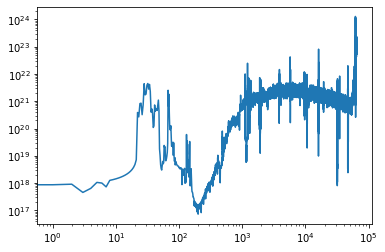

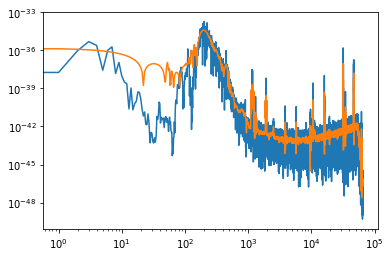

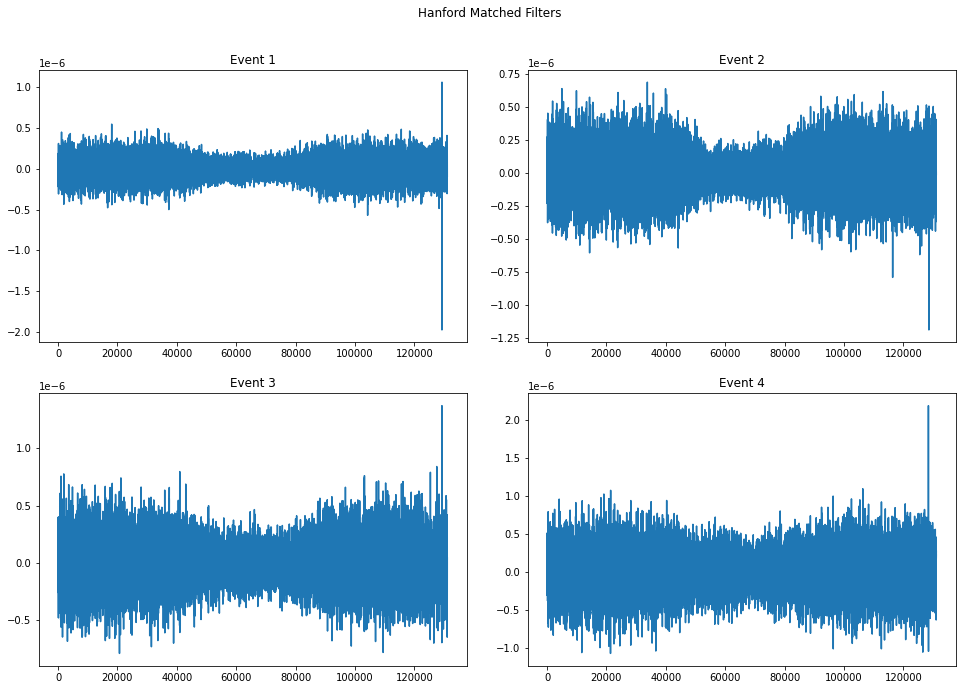

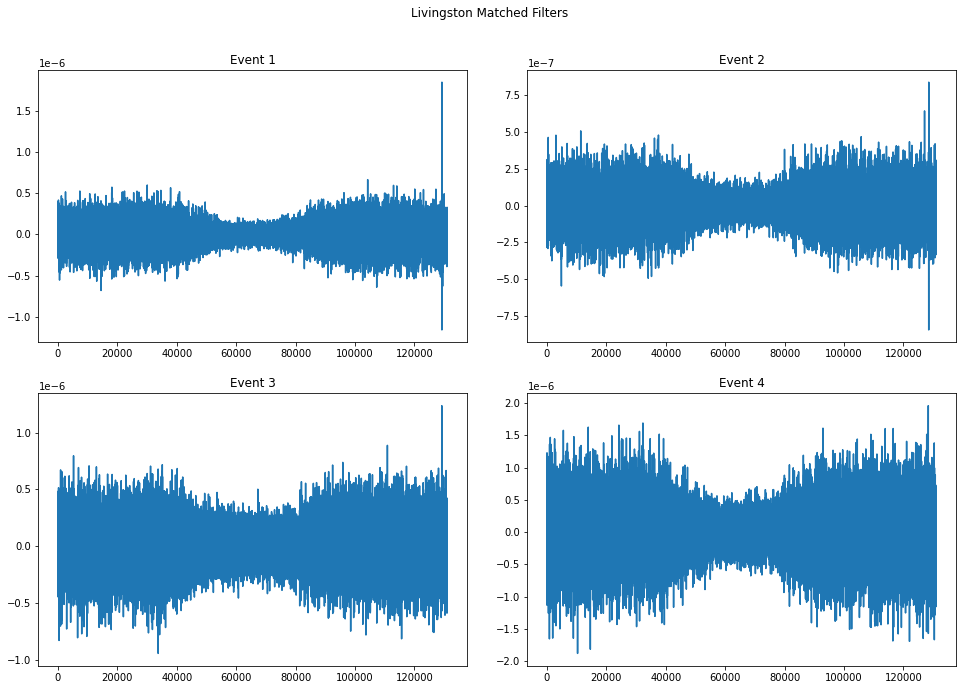

In [4]:
from scipy import signal

#windowing:
def window_tukey(a):
    #apply Tukey window to array
    window=signal.tukey(len(a))
    return a*window

#Window Data and Templates
strain_h_w=np.zeros((4,131072))
strain_l_w=np.zeros((4,131072))
for i in range(len(strain_h)):
    strain_h_w[i,:]=window_tukey(strain_h[i,:])
    strain_l_w[i,:]=window_tukey((strain_l[i,:]+1e-18)) #move Langford strain up so noise is centered at 0
th_w=np.zeros((4,131072))
tl_w=np.zeros((4,131072))
for i in range(len(th)):
    th_w[i,:]=window_tukey(th[i,:])
    tl_w[i,:]=window_tukey(tl[i,:])

#Check that everything is being windowed and read correctly
#plt.figure('strains_w')
#plt.plot(strain_h_w[0,:])
#plt.plot(strain_l_w[0,:])

#plt.figure('templates_w')
#plt.plot(th_w[0,:])
#plt.plot(tl_w[0,:])

#Now, work in Fourier Space
dft_h=np.zeros((4,65537),dtype='complex')
dft_l=np.zeros((4,65537),dtype='complex')
#plt.figure('windowed data') #plot to make sure FT looks reasonable
for i in range(len(dft_h)):
    dft_h[i,:]=np.fft.rfft(strain_h_w[i,:],norm='ortho')
    #plt.loglog(np.abs(dft_h[i,:])) 
    dft_l[i,:]=np.fft.rfft(strain_l_w[i,:],norm='ortho')
    #plt.loglog(np.abs(dft_l[i,:]))
Aft_h=np.zeros((4,65537),dtype='complex')
Aft_l=np.zeros((4,65537),dtype='complex')
#plt.figure('windowed templates') #again, plot to make sure FT worked
for i in range(len(dft_h)):
    Aft_h[i,:]=np.fft.rfft(th_w[i,:],norm='ortho')
    #plt.loglog(np.abs(Aft_h[i,:]))
    Aft_l[i,:]=np.fft.rfft(tl_w[i,:],norm='ortho')
    #plt.loglog(np.abs(Aft_l[i,:]))

#Then, noise (sigma^2) should be the squared magnitude of the FT - (aka the power spectrum). Really, noise is IFT*sigma^2*FT and this N is sigma^2.
N_h=np.abs(dft_h)**2
N_l=np.abs(dft_l)**2 

#Now, let's smooth using Savitzky-Golay Smoothing Filter, width 33, order 4
N_h_sg=signal.savgol_filter(N_h,101,4)
N_l_sg=signal.savgol_filter(N_l,101,4)

#Now, lets make sure we're not overcounting by taking the higher noise value at peaks
Np_h=N_h*0.0
Np_l=N_l*0.0
for i in range(4):
    Np_h[i,:]=np.maximum(N_h[i,:],N_h_sg[i,:])
    Np_l[i,:]=np.maximum(N_l[i,:],N_l_sg[i,:])

#Check that noise is in right spot (normalization) and that we took larger values at peaks
#plt.figure('Npeaks')
plt.loglog(1/np.sqrt(np.abs(Np_h[0])))
plt.savefig('noiseinvertedsqrt.png')

plt.figure('ftgdhgd')
plt.loglog(np.abs(N_h[0]))
plt.loglog(np.abs(N_h_sg[0]))
plt.savefig('smoothednoise.png')

#plt.loglog(np.abs(N_h_sg[0]))
#plt.show()

#print(np.mean(N_h[0]),np.mean(N_h_sg[0])) #power is conserved!

#Now, pre-whitening!
sigma_h=np.sqrt(np.abs(Np_h))
sigma_l=np.sqrt(np.abs(Np_l))

dft_h_white=dft_h/sigma_h 
dft_l_white=dft_l/sigma_l

Aft_h_white=Aft_h/sigma_h
Aft_l_white=Aft_l/sigma_l

#Matched Filter
#calculate RHS of equations, stay in fourier space since N matrix includes FT operator
rhs_h=np.zeros(4)
rhs_l=np.zeros(4)
A_h=np.fft.irfft(Aft_h_white,norm='ortho')
A_l=np.fft.irfft(Aft_l_white,norm='ortho')
for i in range(len(rhs_h)):
    rhs_h[i]=np.real(A_h[i,:]).T@np.real(A_h[i,:])
    rhs_l[i]=np.real(A_l[i,:]).T@np.real(A_l[i,:])    
    #rhs_h[i]=np.real(Aft_h_white[i,:]).T@np.real(Aft_h_white[i,:])
    #rhs_l[i]=np.real(Aft_l_white[i,:]).T@np.real(Aft_l_white[i,:])


m_h=np.zeros((4,131072))
m_l=np.zeros((4,131072))
for i in range(len(m_h)):
    m_h[i,:]=np.fft.irfft(Aft_h_white[i,:]*np.conj(dft_h_white[i,:]),norm='ortho')/rhs_h[i]
    m_l[i,:]=np.fft.irfft(Aft_l_white[i,:]*np.conj(dft_l_white[i,:]),norm='ortho')/rhs_l[i]

#Plot Matched Filters
fig_h, axs_h=plt.subplots(2,2,figsize=(14,10))
fig_h.suptitle('Hanford Matched Filters')
fig_h.tight_layout(pad=3.0)
axs_h[0,0].plot(m_h[0])
axs_h[0,0].set_title('Event 1')
axs_h[0,1].plot(m_h[1])
axs_h[0,1].set_title('Event 2')
axs_h[1,0].plot(m_h[2])
axs_h[1,0].set_title('Event 3')
axs_h[1,1].plot(m_h[3])
axs_h[1,1].set_title('Event 4')
plt.savefig('hanfordMF.png')

fig_l, axs_l=plt.subplots(2,2,figsize=(14,10))
fig_l.suptitle('Livingston Matched Filters')
fig_l.tight_layout(pad=3.0)
axs_l[0,0].plot(m_l[0])
axs_l[0,0].set_title('Event 1')
axs_l[0,1].plot(m_l[1])
axs_l[0,1].set_title('Event 2')
axs_l[1,0].plot(m_l[2])
axs_l[1,0].set_title('Event 3')
axs_l[1,1].plot(m_l[3])
axs_l[1,1].set_title('Event 4')
plt.savefig('livingstonMF.png')

#Noise estimate for each event from matched filter

#Find matched filter peaks
peak_index_h=np.zeros(4)
peak_index_l=np.zeros(4)
for i in range(4):
    peak_index_h[i]=np.argmax(np.abs(m_h[i,:]))
    peak_index_l[i]=np.argmax(np.abs(m_l[i,:]))

#check that we actually found the right peaks
print('\nMatched Filter Peak Locations:')
print('Hanford',peak_index_h)
print('Livingston',peak_index_l) #third Livingston event picks up wrong peak

#calculate matched filter noise
sigma_mf_h=np.zeros(4)
sigma_mf_l=np.zeros(4)
for i in range(len(sigma_mf_h)):
    min_h=int(peak_index_h[i]+100)
    min_l=int(peak_index_l[i]+100)
    sigma_mf_h[i]=np.std(np.abs(m_h[i,min_h:])) #take noise as standard deviation of matched filter after event
    sigma_mf_l[i]=np.std(np.abs(m_l[i,min_l:]))

#Since Livingston 3rd event is close to beginning, take noise estimate up to that point instead of after
sigma_mf_l[2]=np.std(np.abs(m_l[2,:int(peak_index_l[2]-100)]))

#find the maximum matched filter output
signal_h=np.zeros(4)
signal_l=np.zeros(4)
for i in range(len(signal_h)):
    signal_h[i]=np.max(np.abs(m_h[i,:]))
    signal_l[i]=np.max(np.abs(m_l[i,:]))

#calculate signal to noise for matched filters
stn_mf_h=signal_h/sigma_mf_h
stn_mf_l=signal_l/sigma_mf_l

print('\nMatched Filter Signal to Noise:')
print('Hanford',stn_mf_h)
print('Livingston',stn_mf_l)

#Now combined events - add signal to noise ratios in quadrature
stn_mf=np.zeros(4)
for i in range(4):
    stn_mf[i]=np.sqrt(stn_mf_h[i]**2+stn_mf_l[i]**2)

print('Combined',stn_mf)


#Now find analytical signal to noise estimate
#!!!!!!!!!!!!!!!!!!!!!!!
sigma_anal_h=1/np.sqrt(rhs_h)
sigma_anal_l=1/np.sqrt(rhs_l)
#sigmal_anal_h=np.sqrt(np.mean(A_h**2))
#sigmal_anal_l=np.sqrt(np.mean(A_l**2))

#Calculate analytical signal to noise
stn_anal_h=m_h*0.0
stn_anal_l=m_l*0.0
norm=np.sqrt(dt_h*2) #This is almost definitely wrong
for i in range(4):
    stn_anal_h[i]=np.abs(m_h[i,:])/sigma_anal_h[i]
    stn_anal_l[i]=np.abs(m_l[i,:])/sigma_anal_l[i]

print('\nAnalytic Signal to Noise Estimate:') #These do not match matched filter
print('Hanford')
for i in range(4):
    print(np.sum(stn_anal_h[i]))
print('Livingston')
for i in range(4):
    print(np.sum(stn_anal_l[i]))


#Now, let's look at the frequencies
#find contribution of each frequency to chi squared (FT(template)/sigma) and normalize so sum=1
#Could do this with analytic signal to noise if I got that working...
chisq_cont_h=np.real(Aft_h)*0.0
chisq_cont_l=np.real(Aft_l)*0.0
for i in range(4):
    chisq_cont_h[i,:]=np.abs(Aft_h_white[i,:])**2/np.sum(np.abs(Aft_h_white[i,:])**2) #normalize so sum is 1
    chisq_cont_l[i,:]=np.abs(Aft_l_white[i,:])**2/np.sum(np.abs(Aft_l_white[i,:])**2) 

index_half_h=np.zeros(4)
index_half_l=np.zeros(4)
for j in range(4):
    for i in range(len(chisq_cont_h[j])):
        if np.sum(chisq_cont_h[j,:i])>=0.5:
            if index_half_h[j] == 0: 
                index_half_h[j]=i #index at halfway point of weight
    for k in range(len(chisq_cont_l[j])):
        if np.sum(chisq_cont_l[j,:k])>=0.5:
            if index_half_l[j] == 0: 
                index_half_l[j]=k #index at halfway point of weight

#Find frequencies corresponding to fourier space indices?????
freqs=np.fft.fftfreq(len(th[0]))

print('\nFrequency Space Indices of Half-Weight:')
print('Hanford',index_half_h)
print('Livingston',index_half_l)
#how to convert indices into actual frequencies

#Part (e): print uncertainty in time (aka time between data points)
print('\ndt=',dt_h[0]) #dt is same for each detector and each event

print('\nPlots:')
